# Graph Environment Experiments (1)

Referenced Work: [Momennejad et al., 2017](https://www.nature.com/articles/s41562-017-0180-8).

In [1]:
# Uncomment below lines and run this cell to install neuronav and requirements for colab.

#!git clone https://github.com/awjuliani/neuro-nav
#!pip install ./neuro-nav[experiments_remote]

In [2]:
from neuronav.envs.graph_env import GraphEnv, GraphObsType
from neuronav.envs.graph_structures import GraphStructure
from neuronav.agents.td_agents import TDSR
from neuronav.agents.dyna_agents import DynaSR
from neuronav.agents.mb_agents import MBV, SRMB
from neuronav.utils import run_episode

import numpy as np
from neuronav.notebook_helpers import (
    plot_graph_experiment_results,
    get_scores,
    AgentParams,
    init_agents,
    calc_revaluation,
)

### Set parameters for experiment

In [3]:
num_eps = 100
num_steps = 3
num_reps = 10

agent_dict = {"TDSR": TDSR, "DynaSR": DynaSR, "SRMB": SRMB, "MBV": MBV}

agent_params = AgentParams(
    poltype="softmax",
    beta=1e-4,
    epsilon=0.1,
    learning_rate=1e-1,
    gamma=0.9,
)

### Define experiment-specific functions

In [4]:
def gen_init_prefs(env, agents, num_eps, num_steps):
    init_state_prefs = []
    for agent in agents:
        for i in range(num_eps):
            if i % 2 == 0:
                start_pos = 1
            else:
                start_pos = 0
            agent, _, _ = run_episode(env, agent, num_steps, start_pos)
        Qs = agent.Q[:, :2]
        max_Q_idx = np.argmax(Qs)
        init_state_prefs.append((agent.__class__.__name__, max_Q_idx, Qs))
    return init_state_prefs


def control_func(agent_types):
    env = GraphEnv(GraphStructure.human_a, obs_type=GraphObsType.index)
    env.reset()
    env.render()
    agents = init_agents(env, agent_types, agent_params)
    init_state_prefs = gen_init_prefs(env, agents, num_eps, num_steps)
    control_state_prefs = gen_init_prefs(env, agents, num_eps, num_steps)
    return calc_revaluation(init_state_prefs, control_state_prefs)


def reward_func(agent_types):
    env = GraphEnv(GraphStructure.human_a, obs_type=GraphObsType.index)
    agents = init_agents(env, agent_types, agent_params)
    init_state_prefs = gen_init_prefs(env, agents, num_eps, num_steps)

    env.struct_objects["rewards"][4] = 1
    env.struct_objects["rewards"][5] = 10

    env.reset()
    env.render()

    rew_state_prefs = []
    for agent in agents:
        for i in range(num_eps):
            if i % 2 == 0:
                start_pos = 2
            else:
                start_pos = 3
            agent, _, _ = run_episode(env, agent, num_steps, start_pos)
        Qs = agent.Q[:, :2]
        max_Q_idx = np.argmax(Qs)
        rew_state_prefs.append((agent.__class__.__name__, max_Q_idx, Qs))

    return calc_revaluation(init_state_prefs, rew_state_prefs)


def transition_func(agent_types):
    env = GraphEnv(GraphStructure.human_a, obs_type=GraphObsType.index)
    agents = init_agents(env, agent_types, agent_params)
    init_state_prefs = gen_init_prefs(env, agents, num_eps, num_steps)

    env.edges[2] = [5]
    env.edges[3] = [4]

    env.reset()
    env.render()

    trans_state_prefs = []
    for agent in agents:
        for i in range(num_eps):
            if i % 2 == 0:
                start_pos = 2
            else:
                start_pos = 3
            agent, _, _ = run_episode(env, agent, num_steps, start_pos)
        Qs = agent.Q[:, :2]
        max_Q_idx = np.argmax(Qs)
        trans_state_prefs.append((agent.__class__.__name__, max_Q_idx, Qs))

    return calc_revaluation(init_state_prefs, trans_state_prefs)

### Run experimental conditions

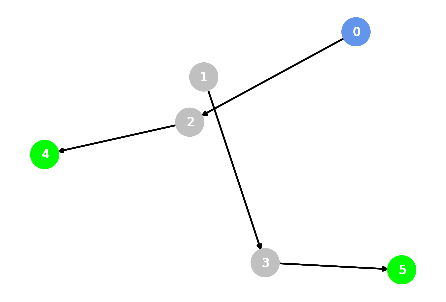

In [5]:
# Control condition
all_cs = get_scores(control_func, agent_dict, num_reps)

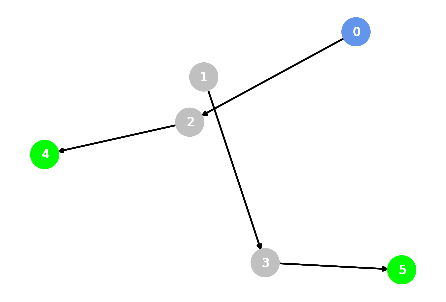

In [6]:
# Reward revaluation condition
all_rs = get_scores(reward_func, agent_dict, num_reps)

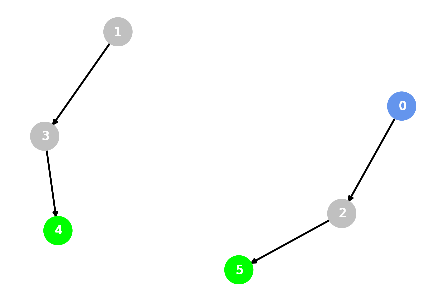

In [7]:
# Transition revaluation condition
all_ts = get_scores(transition_func, agent_dict, num_reps)

### Plot results

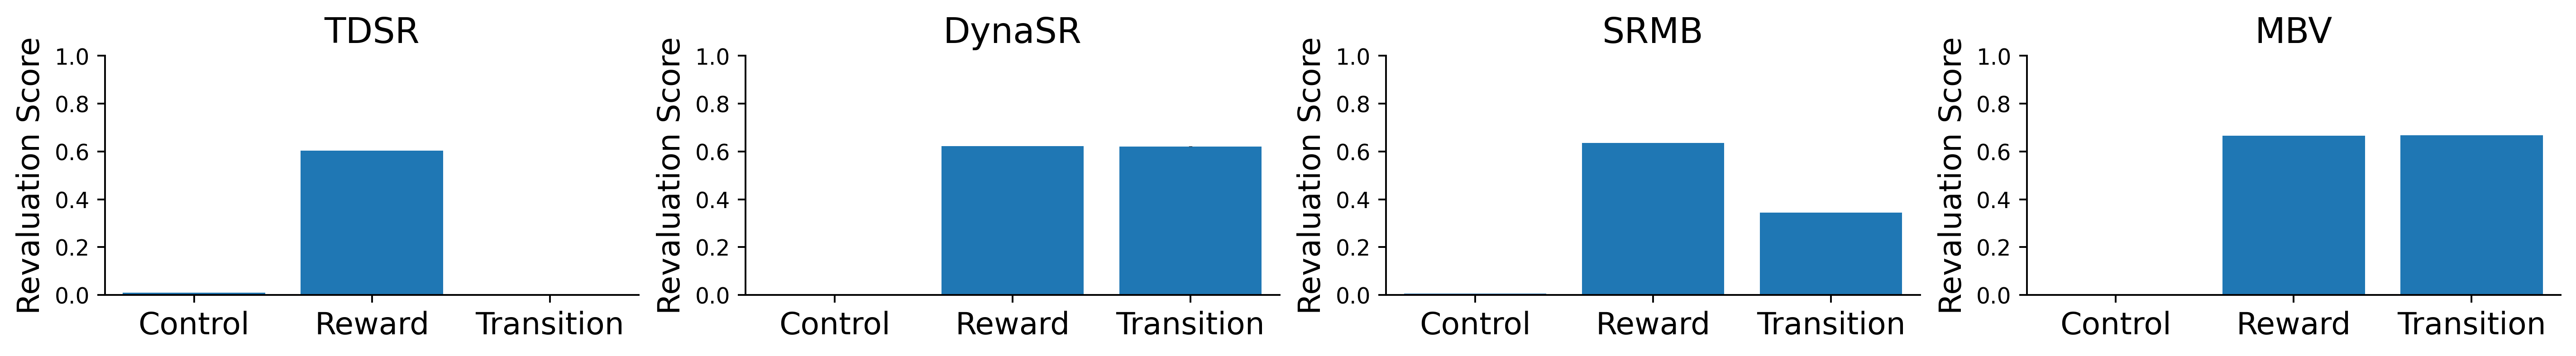

In [8]:
result_dict = {"Control": all_cs, "Reward": all_rs, "Transition": all_ts}
plot_graph_experiment_results(list(agent_dict.keys()), result_dict, "experiment_1")